# Importando librerías

In [1]:
!pip install pandas-profiling==2.7.1
# !pip uninstall pandas-profiling

     |████████████████████████████████| 252 kB 14.3 MB/s 
     |████████████████████████████████| 4.7 MB 38.2 MB/s 
     |████████████████████████████████| 675 kB 47.2 MB/s 
     |████████████████████████████████| 58 kB 4.0 MB/s 
     |████████████████████████████████| 812 kB 41.0 MB/s 
     |████████████████████████████████| 38.2 MB 26 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=f505817fd313e198d72cfa1115dff18fd598a72a11ca3f1d87e6a570cf9cbaaa
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=1760b0c5b1028cc0f1d3b9c164f1c2b417d72d323bd53376ae546f3f0aa0f40c
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built htmlmin imagehash
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstallin

In [2]:
import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(12,8)})

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = '/content/drive/MyDrive/Maestria/SemestreII/CDA Final/datos/'

In [5]:
customers = pd.read_csv(dir+"olist_customers_dataset.csv")
geolocation = pd.read_csv(dir+"olist_geolocation_dataset.csv")
geolocation.drop_duplicates(inplace=True)
items = pd.read_csv(dir+"olist_order_items_dataset.csv")
payments = pd.read_csv(dir+"olist_order_payments_dataset.csv")
reviews = pd.read_csv(dir+"olist_order_reviews_dataset.csv")
orders = pd.read_csv(dir+"olist_orders_dataset.csv")
products = pd.read_csv(dir+"olist_products_dataset.csv")
sellers = pd.read_csv(dir+"olist_sellers_dataset.csv")
category = pd.read_csv(dir+"product_category_name_translation.csv")

# Preparación de los datos

## Unión de datasets

Se realiza la unión de los diferentes dataset con base en las revisiones para obtener más características que permitan obtener información más detallada:

Para esto se utiliza:
* Reviews
* Orders
* Payments
* Customers
* Geolocation
* Items


In [6]:
# Preparar dataset CLIENTE con la geolocalización del cliente
dataCustomers = pd.merge(customers,geolocation,left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix',how='left')
dataCustomers.rename(columns={'geolocation_lat' : 'cliente_lat','geolocation_lng' : 'cliente_long'}, inplace=True)
dataCustomers.drop(columns = ["geolocation_city", "geolocation_state","geolocation_zip_code_prefix","customer_zip_code_prefix"], inplace = True)
dataCustomers.head(1)

,customer_id,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,-20.509897,-47.397866


In [7]:
# Dejar solo un registro por cliente
dataCustomers=dataCustomers.groupby("customer_id").max().reset_index()
dataCustomers.head(3)

,customer_id,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,osasco,SP,-23.491469,-46.762668
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,itapecerica,MG,-20.341986,-45.107222
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,nova venecia,ES,-18.494666,-40.385265


In [8]:
# Preparar dataset VENDEDOR con la geolocalización del cliente
dataVendedor = pd.merge(sellers,geolocation,left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix',how='left')
dataVendedor.rename(columns={'geolocation_lat' : 'vendedor_lat','geolocation_lng' : 'vendedor_long'}, inplace=True)
dataVendedor.drop(columns = ["geolocation_city", "geolocation_state","geolocation_zip_code_prefix","seller_zip_code_prefix"], inplace = True)
dataVendedor.head(1)

,seller_id,seller_city,seller_state,vendedor_lat,vendedor_long
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,-22.898536,-47.063125


In [9]:
# Dejar solo un registro por vendedor y así evitar duplicados
dataVendedor = dataVendedor.groupby("seller_id").max().reset_index()
dataVendedor.head(3)

,seller_id,seller_city,seller_state,vendedor_lat,vendedor_long
0,0015a82c2db000af6aaaf3ae2ecb0532,santo andre,SP,-23.625599,-46.532709
1,001cca7ae9ae17fb1caed9dfb1094831,cariacica,ES,-20.254806,-40.390723
2,001e6ad469a905060d959994f1b41e4f,sao goncalo,RJ,-22.865654,-43.019154


In [10]:
# MERGE de todos los datasets de acuerdo a la documentación
data = pd.merge(reviews,orders,on='order_id')
data = pd.merge(data, items, on='order_id')
data = pd.merge(data,payments,on='order_id')
data = pd.merge(data,dataVendedor,on='seller_id')
data = pd.merge(data,dataCustomers,on='customer_id')
data = pd.merge(data,products,on='product_id')

In [11]:
# En otro dataset, hacer el calculo agrupado de cuantos productos hay por orden para tomar este dato en los campos calculados
cantidad_productos_orden =  data.groupby("order_id").count()[["order_item_id"]].reset_index()
cantidad_productos_orden=cantidad_productos_orden.rename(columns={'order_item_id':'cant_prods_orden'})
cantidad_productos_orden.head(1)

,order_id,cant_prods_orden
0,00010242fe8c5a6d1ba2dd792cb16214,1


In [12]:
# Hacer el merge para traer la cantidad de productos en la orden
data = pd.merge(data,cantidad_productos_orden,on='order_id')

**Calculo del comportamiento del score por grupos**

In [13]:
prom_score_vendedor = data.groupby('seller_id').mean()[["review_score"]].reset_index()
prom_score_vendedor.columns = ['seller_id', "prom_score_vendedor"]

prom_score_producto = data.groupby('product_id').mean()[["review_score"]].reset_index()
prom_score_producto.columns = ['product_id', "prom_score_producto"]

prom_score_categoria = data.groupby('product_category_name').mean()[["review_score"]].reset_index()
prom_score_categoria.columns = ['product_category_name', "prom_score_categoria"]

In [14]:
data = pd.merge(data,prom_score_vendedor,on='seller_id')
data = pd.merge(data,prom_score_producto,on='product_id')
data = pd.merge(data,prom_score_categoria,on='product_category_name')

In [15]:
data.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_city,seller_state,vendedor_lat,vendedor_long,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cant_prods_orden,prom_score_vendedor,prom_score_producto,prom_score_categoria
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.50,4.10747
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.50,4.10747
2,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,NaN,NaN,2018-04-10 00:00:00,2018-04-11 11:30:43,b1757da2a461d581e1a3b280ca181b7c,delivered,2018-03-26 11:02:31,2018-03-26 11:15:38,2018-03-26 22:58:37,2018-04-09 21:53:23,2018-04-27 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-04-02 11:15:38,185.0,20.26,1,credit_card,3,205.26,sao joaquim da barra,SP,-20.556561,-47.848368,059ba8400bf965adf606ecc7ef3396e9,taquari,RS,-29.760369,-51.846034,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,1,4.289855,4.50,4.10747
3,cb18f53b563f0bdeb76be0376ddd6b6a,efd626e6a12a82d76e456e34093f8356,5,NaN,NaN,2017-12-28 00:00:00,2017-12-30 12:07:50,da2bd16b131bc90653b87fe4d8fd266e,delivered,2017-12-07 20:33:24,2017-12-07 20:51:05,2017-12-08 18:12:34,2017-12-27 18:19:53,2018-01-08 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2017-12-14 20:51:05,185.0,17.05,1,credit_card,2,202.05,sao joaquim da barra,SP,-20.556561,-47.848368,62a25a159f9fd2ab7c882d9407f49aa9,uba,MG,-21.085348,-42.892585,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,1,4.289855,4.50,4.10747
4,5fdb2ed7aa0f1b1c9642175b302e38af,b0bc656fed47584c160f8cff2d7b8bbd,5,NaN,NaN,2018-03-17 00:00:00,2018-03-17 17:36:27,f4ad1c9eb0bed4469cbe0ff8f47bf634,delivered,2018-02-27 13:56:12,2018-02-27 14:10:22,2018-02-27 23:04:47,2018-03-16 14:16:19,2018-03-23 00:00:00,1,1acb18fc869c5489d5f76abcd681165e,6d803cb79cc31c41c4c789a75933b3c7,2018-03-06 14:10:22,135.0,18.20,1,credit_card,1,306.40,sao joaquim da barra,SP,-20.556561,-47.848368,86243f3e50e3b844b1d7bd850c4d2623,uberlandia,MG,-18.911981,-48.271178,esporte_lazer,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,2,4.289855,4.25,4.10747


In [16]:
# GUARDAR el dataset unificado
data.to_csv('/content/drive/MyDrive/Maestria/SemestreII/CDA Final/merged_df.csv')

In [17]:
# VISTA general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115634 entries, 0 to 115633
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      115634 non-null  object 
 1   order_id                       115634 non-null  object 
 2   review_score                   115634 non-null  int64  
 3   review_comment_title           13810 non-null   object 
 4   review_comment_message         48918 non-null   object 
 5   review_creation_date           115634 non-null  object 
 6   review_answer_timestamp        115634 non-null  object 
 7   customer_id                    115634 non-null  object 
 8   order_status                   115634 non-null  object 
 9   order_purchase_timestamp       115634 non-null  object 
 10  order_approved_at              115620 non-null  object 
 11  order_delivered_carrier_date   114437 non-null  object 
 12  order_delivered_customer_date 

## Cambio de tipo de variable

In [18]:
data.dtypes

review_id                         object
order_id                          object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
seller_city     

### Cambio de String a Fecha

In [19]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date'])

## Revisión de duplicados

In [20]:
data.duplicated().sum()

0

No se encuentran observaciones duplicadas en el dataset

## Tratamiento de nulos

Se identifica que las siguientes variables tienen observaciones con valores nulos:

In [21]:
data.isnull().sum()

review_id                             0
order_id                              0
review_score                          0
review_comment_title             101824
review_comment_message            66716
review_creation_date                  0
review_answer_timestamp               0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1197
order_delivered_customer_date      2402
order_estimated_delivery_date         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
seller_city                           0


Se procede a la eliminación de las siguientes columnas debido a la alta cantidad de valores nulos:
* review_comment_title
* review_comment_message

In [22]:
data.drop(columns = ["review_comment_title", "review_comment_message"], inplace = True)

Así mismo, se procede a la eliminación de las observaciones con algún valor nulo

In [23]:
data.dropna(inplace=True)

## Creación de nuevas variables de estudio

Se obtiene la cantidad de días que le tomó al cliente recibir su pedido después de realizar la compra. Para esto se restan la fecha de entrega y la fecha de compra y se eliminan del dataset:

* order_purchase_timestamp
* order_delivered_customer_date



In [24]:
from math import sin, cos, sqrt, atan2, radians
data['distancia_kms'] = data[['vendedor_lat','vendedor_long','cliente_lat','cliente_long']].apply(
    lambda row : round(6373.0 * (2 * atan2(sqrt((sin((radians(row['cliente_lat']) - radians(row['vendedor_lat']))/2))**2 + cos(radians(row['vendedor_lat'])) * cos(radians(row['cliente_lat'])) * (sin((radians(row['cliente_long']) - radians(row['vendedor_long']))/2))**2), sqrt(1-((sin((radians(row['cliente_lat']) - radians(row['vendedor_lat']))/2))**2 + cos(radians(row['vendedor_lat'])) * cos(radians(row['cliente_lat'])) * (sin((radians(row['cliente_long']) - radians(row['vendedor_long']))/2))**2)))))
    , axis=1
)
data.head(1)

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_city,seller_state,vendedor_lat,vendedor_long,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cant_prods_orden,prom_score_vendedor,prom_score_producto,prom_score_categoria,distancia_kms
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.5,4.10747,346


In [25]:
data['flete_x_prod'] = data[['freight_value','cant_prods_orden']].apply(
    lambda row : round(row['freight_value'] / row['cant_prods_orden'],2), axis=1
)
data.head(1)

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_city,seller_state,vendedor_lat,vendedor_long,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cant_prods_orden,prom_score_vendedor,prom_score_producto,prom_score_categoria,distancia_kms,flete_x_prod
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.5,4.10747,346,6.82


In [26]:
# FECHAS

In [27]:
#  Tiempo desde que se entrega a la empresa transportadora hasta que se entrega
data["tiempo_entrega_dias"] = pd.to_datetime(data["order_delivered_customer_date"]) -  pd.to_datetime(data["order_delivered_carrier_date"])
data['tiempo_entrega_dias'] = data['tiempo_entrega_dias'].astype('timedelta64[D]')

In [28]:
#  Tiempo desde que el cliente compró hasta que se aprobó la compra
data["tiempo_aprobacion_horas"] = pd.to_datetime(data["order_approved_at"]) -  pd.to_datetime(data["order_purchase_timestamp"])
data['tiempo_aprobacion_horas'] = data['tiempo_aprobacion_horas'].astype('timedelta64[h]')

In [29]:
#  Tiempo de alistamiento del prodcuto. Desde que se aprueba la compra hasta que se entrega al transportador
data["tiempo_alistamiento_dias"] = pd.to_datetime(data["order_approved_at"]) -  pd.to_datetime(data["order_purchase_timestamp"])
data['tiempo_alistamiento_dias'] = data['tiempo_alistamiento_dias'].astype('timedelta64[D]')

In [30]:
data.head(1)

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_city,seller_state,vendedor_lat,vendedor_long,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cant_prods_orden,prom_score_vendedor,prom_score_producto,prom_score_categoria,distancia_kms,flete_x_prod,tiempo_entrega_dias,tiempo_aprobacion_horas,tiempo_alistamiento_dias
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.5,4.10747,346,6.82,4.0,0.0,0.0


Se crea la siguiente variable para identificar si el producto no llegó en la fecha estipulada

In [31]:
data["entrega_a_transportador_atrasada"] = np.where(pd.to_datetime(data["order_delivered_carrier_date"]) >  pd.to_datetime(data["shipping_limit_date"]), 1, 0)

In [32]:
data["entrega_a_cliente_atrasada"] = np.where(pd.to_datetime(data["order_delivered_customer_date"]) >  pd.to_datetime(data["order_estimated_delivery_date"]), 1, 0)

In [33]:
data["mejor_producto_respecto_a_categ"] = np.where(data["prom_score_producto"] > data["prom_score_categoria"], 1, 0)

In [34]:
data.head(1)

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_city,seller_state,vendedor_lat,vendedor_long,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cant_prods_orden,prom_score_vendedor,prom_score_producto,prom_score_categoria,distancia_kms,flete_x_prod,tiempo_entrega_dias,tiempo_aprobacion_horas,tiempo_alistamiento_dias,entrega_a_transportador_atrasada,entrega_a_cliente_atrasada,mejor_producto_respecto_a_categ
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.5,4.10747,346,6.82,4.0,0.0,0.0,0,0,1


## Eliminación de variables

La variable order_status solo tiene 11 valores cancelados. Por tal razón se decide eliminarlos y trabajar unicamente con ordenes entregadas.

In [35]:
data["order_status"].value_counts()/len(data)

delivered    0.999938
canceled     0.000062
Name: order_status, dtype: float64

In [36]:
data = data.query('order_status == "delivered"')

In [37]:
data

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_city,seller_state,vendedor_lat,vendedor_long,customer_unique_id,customer_city,customer_state,cliente_lat,cliente_long,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cant_prods_orden,prom_score_vendedor,prom_score_producto,prom_score_categoria,distancia_kms,flete_x_prod,tiempo_entrega_dias,tiempo_aprobacion_horas,tiempo_alistamiento_dias,entrega_a_transportador_atrasada,entrega_a_cliente_atrasada,mejor_producto_respecto_a_categ
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.500000,4.107470,346,6.82,4.0,0.0,0.0,0,0,1
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,1,credit_card,8,397.26,sao joaquim da barra,SP,-20.556561,-47.848368,68a5590b9926689be4e10f4ae2db21a8,osasco,SP,-23.493888,-46.758469,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.500000,4.107470,346,6.82,4.0,0.0,0.0,0,0,1
2,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,2018-04-10 00:00:00,2018-04-11 11:30:43,b1757da2a461d581e1a3b280ca181b7c,delivered,2018-03-26 11:02:31,2018-03-26 11:15:38,2018-03-26 22:58:37,2018-04-09 21:53:23,2018-04-27 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-04-02 11:15:38,185.0,20.26,1,credit_card,3,205.26,sao joaquim da barra,SP,-20.556561,-47.848368,059ba8400bf965adf606ecc7ef3396e9,taquari,RS,-29.760369,-51.846034,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,1,4.289855,4.500000,4.107470,1100,20.26,13.0,0.0,0.0,0,0,1
3,cb18f53b563f0bdeb76be0376ddd6b6a,efd626e6a12a82d76e456e34093f8356,5,2017-12-28 00:00:00,2017-12-30 12:07:50,da2bd16b131bc90653b87fe4d8fd266e,delivered,2017-12-07 20:33:24,2017-12-07 20:51:05,2017-12-08 18:12:34,2017-12-27 18:19:53,2018-01-08 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2017-12-14 20:51:05,185.0,17.05,1,credit_card,2,202.05,sao joaquim da barra,SP,-20.556561,-47.848368,62a25a159f9fd2ab7c882d9407f49aa9,uba,MG,-21.085348,-42.892585,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,1,4.289855,4.500000,4.107470,519,17.05,19.0,0.0,0.0,0,0,1
4,5fdb2ed7aa0f1b1c9642175b302e38af,b0bc656fed47584c160f8cff2d7b8bbd,5,2018-03-17 00:00:00,2018-03-17 17:36:27,f4ad1c9eb0bed4469cbe0ff8f47bf634,delivered,2018-02-27 13:56:12,2018-02-27 14:10:22,2018-02-27 23:04:47,2018-03-16 14:16:19,2018-03-23 00:00:00,1,1acb18fc869c5489d5f76abcd681165e,6d803cb79cc31c41c4c789a75933b3c7,2018-03-06 14:10:22,135.0,18.20,1,credit_card,1,306.40,sao joaquim da barra,SP,-20.556561,-47.848368,86243f3e50e3b844b1d7bd850c4d2623,uberlandia,MG,-18.911981,-48.271178,esporte_lazer,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,2,4.289855,4.250000,4.107470,188,9.10,16.0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Se eliminan las siguientes variables ya que no aportan información valiosa al estudio del problema planteado o son columnas con información duplicada:

In [38]:
data.drop(columns=["review_creation_date", 
        "review_answer_timestamp", 
        "order_approved_at", 
        "order_delivered_carrier_date", 
        "order_estimated_delivery_date", 
        "customer_unique_id",
        "order_item_id",
        "review_id",
        "order_id",
        "customer_id",
        "product_id",
        "seller_id",
        "order_status",
        "shipping_limit_date",
        "order_purchase_timestamp",
        "order_delivered_customer_date",
        "payment_sequential",
        "vendedor_long",
        "vendedor_lat",
        "cliente_lat",
        "cliente_long"       
        
        ], inplace = True)

In [39]:
# Columnas resultantes
data.columns

Index(['review_score', 'price', 'freight_value', 'payment_type',
       'payment_installments', 'payment_value', 'seller_city', 'seller_state',
       'customer_city', 'customer_state', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'cant_prods_orden',
       'prom_score_vendedor', 'prom_score_producto', 'prom_score_categoria',
       'distancia_kms', 'flete_x_prod', 'tiempo_entrega_dias',
       'tiempo_aprobacion_horas', 'tiempo_alistamiento_dias',
       'entrega_a_transportador_atrasada', 'entrega_a_cliente_atrasada',
       'mejor_producto_respecto_a_categ'],
      dtype='object')

In [40]:
data

,review_score,price,freight_value,payment_type,payment_installments,payment_value,seller_city,seller_state,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,cant_prods_orden,prom_score_vendedor,prom_score_producto,prom_score_categoria,distancia_kms,flete_x_prod,tiempo_entrega_dias,tiempo_aprobacion_horas,tiempo_alistamiento_dias,entrega_a_transportador_atrasada,entrega_a_cliente_atrasada,mejor_producto_respecto_a_categ
0,4,185.0,13.63,credit_card,8,397.26,sao joaquim da barra,SP,osasco,SP,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.500000,4.107470,346,6.82,4.0,0.0,0.0,0,0,1
1,4,185.0,13.63,credit_card,8,397.26,sao joaquim da barra,SP,osasco,SP,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,2,4.289855,4.500000,4.107470,346,6.82,4.0,0.0,0.0,0,0,1
2,5,185.0,20.26,credit_card,3,205.26,sao joaquim da barra,SP,taquari,RS,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,1,4.289855,4.500000,4.107470,1100,20.26,13.0,0.0,0.0,0,0,1
3,5,185.0,17.05,credit_card,2,202.05,sao joaquim da barra,SP,uba,MG,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,1,4.289855,4.500000,4.107470,519,17.05,19.0,0.0,0.0,0,0,1
4,5,135.0,18.20,credit_card,1,306.40,sao joaquim da barra,SP,uberlandia,MG,esporte_lazer,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,2,4.289855,4.250000,4.107470,188,9.10,16.0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115629,5,979.0,49.30,credit_card,1,1028.30,guarulhos,SP,ananindeua,PA,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0,1,4.422222,4.333333,3.266667,2463,49.30,19.0,0.0,0.0,0,0,1
115630,5,979.0,39.11,credit_card,8,1018.11,guarulhos,SP,porto alegre,RS,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0,1,4.422222,4.333333,3.266667,866,39.11,6.0,0.0,0.0,0,0,1
115631,5,83.9,19.78,boleto,1,103.68,catanduva,SP,duque de caxias,RJ,portateis_cozinha_e_preparadores_de_alimentos,60.0,1304.0,4.0,650.0,22.0,6.0,14.0,1,4.400000,5.000000,3.266667,612,19.78,9.0,84.0,3.0,0,0,1
115632,4,102.9,14.30,credit_card,2,117.20,catanduva,SP,aracoiaba da serra,SP,portateis_cozinha_e_preparadores_de_alimentos,58.0,792.0,4.0,750.0,30.0,30.0,30.0,1,4.400000,4.000000,3.266667,299,14.30,4.0,0.0,0.0,0,0,1


In [41]:
data = data.reset_index()

## Pandas profiling

In [42]:
from pandas_profiling import ProfileReport
ProfileReport(data, minimal=True)

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
# GUARDAR dataset procesado
data.to_csv('/content/drive/MyDrive/Maestria/SemestreII/CDA Final/procesado_df.csv')

## Normalizar y escalar

In [ ]:
estimators_normalized = [
              ('encoder', OrdinalEncoder()),
              ('normalize', MinMaxScaler()),
             ]             
pipe_normalized = Pipeline(estimators_normalized)
pipe_normalized

Pipeline(memory=None,
         steps=[('encoder',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('normalize', MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [ ]:
data_norm = pd.DataFrame(pipe_normalized.fit_transform(data), columns=data.columns)
data_norm.head()

,df_index,review_score,payment_sequential,payment_type,payment_installments,payment_value,customer_city,customer_state,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_time_days,delayed
0,0.000000,0.75,0.0,0.333333,0.347826,0.831398,0.629749,0.961538,0.628968,0.162375,0.444444,0.578125,0.283917,0.0,0.388453,0.234694,0.277228,0.311828,0.042254,1.0
1,0.000006,0.75,0.0,0.333333,0.347826,0.831398,0.629749,0.961538,0.628968,0.162375,0.444444,0.578125,0.283917,0.0,0.388453,0.234694,0.277228,0.311828,0.042254,1.0
2,0.000012,1.00,0.0,0.333333,0.043478,0.263419,0.611373,0.961538,0.352992,0.084970,0.611111,0.656250,0.159810,0.0,0.070670,0.122449,0.118812,0.086022,0.063380,0.0
3,0.000018,1.00,0.0,0.333333,0.043478,0.263419,0.611373,0.961538,0.352992,0.084970,0.611111,0.656250,0.159810,0.0,0.070670,0.122449,0.118812,0.086022,0.063380,0.0
4,0.000024,1.00,0.0,0.333333,0.043478,0.562243,0.821704,0.153846,0.556288,0.602212,0.611111,0.843750,0.629378,0.0,0.700231,0.132653,0.178218,0.150538,0.091549,0.0


In [ ]:
# data_norm.to_csv("datos_regresión.csv")

## Correlaciones entre variables

In [ ]:
sns.heatmap(data_norm.corr())

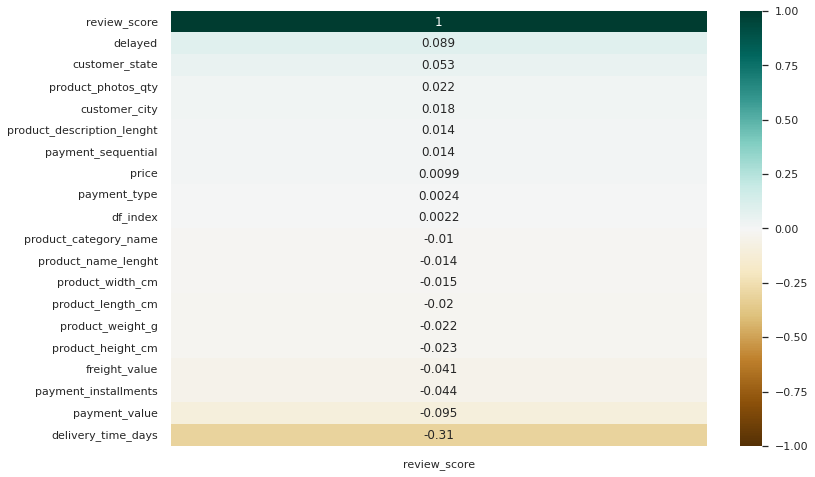

In [ ]:
heatmap = sns.heatmap(data_norm.corr()[['review_score']].sort_values(by='review_score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')